In [1]:
import pickle
import pandas as pd

In [2]:
with open("/home/eeisenst/workspace/compassionai/data-registry/processed_datasets/part-of-speech-intersyllabic-olive/train.pkl", "rb") as f:
    train_data = pickle.load(f)
with open("/home/eeisenst/workspace/compassionai/data-registry/processed_datasets/part-of-speech-intersyllabic-olive/test.pkl", "rb") as f:
    test_data = pickle.load(f)

In [3]:
len(train_data), len(test_data)

(28167, 3129)

In [4]:
train_words = set([' '.join(map(str, word)) for words, _ in train_data for word in words])
len(list(train_words))

20628

In [5]:
test_words = set([' '.join(map(str, word)) for words, _ in test_data for word in words])
len(list(test_words))

5703

In [6]:
len(list(test_words - train_words))

1261

In [7]:
test_word_lens = pd.Series([len(word) for word in test_words])

<AxesSubplot:>

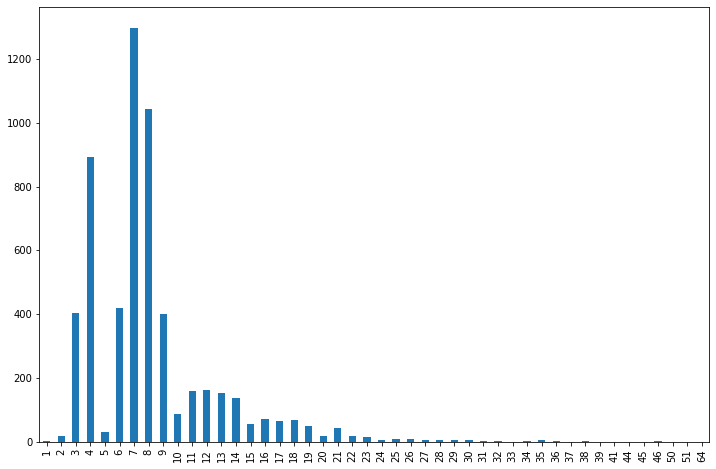

In [8]:
test_word_lens.value_counts().sort_index().plot(kind='bar', figsize=(12,8))

# Classification metrics on new words

In [9]:
from tqdm.auto import tqdm

In [10]:
from cai_manas.part_of_speech.pos_tagger import PartOfSpeechTagger

In [11]:
tagger = PartOfSpeechTagger("part-of-speech-intersyllabic-olive-cormorant")

In [12]:
import torch

torch.LongTensor([[1,2,3,4]])

tensor([[1, 2, 3, 4]])

In [13]:
res_tokens, res_tags, res_labels = [], [], []
for datum in tqdm(test_data):
    # _, cur_tags = tagger.predict_tags(tagger.tokenizer.decode([token for word in datum[0] for token in word]))
    cur_tags = tagger.predict_tokens([token for word in datum[0] for token in word])
    cur_tags = [tagger.id_to_label_map[pred] for pred in cur_tags[1:-1]]
    res_tokens.append(datum[0])
    res_tags.append(cur_tags)
    seq_labels = []
    for word, word_label in zip(datum[0], datum[1]):
        seq_labels.append(word_label)
        for _ in range(len(word) - 1):
            seq_labels.append('[MASK]')
    res_labels.append(seq_labels)

  0%|          | 0/3129 [00:00<?, ?it/s]

In [33]:
test_word = list(test_words - train_words)[4]
test_word

'1014 9450'

In [89]:
strange_tags, strange_labels = [], []
# for test_word in tqdm(list(test_words.intersection(train_words))):
for test_word in tqdm(list(test_words - train_words)):
    test_tokens = list(map(int, test_word.split(' ')))
    for example, tags, labels in zip(res_tokens, res_tags, res_labels):
        example_str = [' '.join(map(str, word)) for word in example]
        if test_word in example_str:
            word_idx = example.index(test_tokens)
            tag_idx = sum([len(word) for word in example[:word_idx]])
            strange_tags.extend(tags[tag_idx:tag_idx+len(example[word_idx])])
            strange_labels.extend(labels[tag_idx:tag_idx+len(example[word_idx])])
            # test_word_tokens = list(map(int, test_word.split(' ')))
            # print([tagger.tokenizer.decode(id_) for id_ in example], tags, labels)
            # print(tagger.tokenizer.decode(test_word_tokens))
            # positives.append(example)
            # break

  0%|          | 0/1261 [00:00<?, ?it/s]

In [90]:
from sklearn.metrics import precision_recall_fscore_support

In [91]:
precision, recall, f1, support = precision_recall_fscore_support(strange_labels, strange_tags)

/home/eeisenst/miniconda3/envs/cai-garland/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/eeisenst/miniconda3/envs/cai-garland/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
for tag, tag_f1, support in zip([tagger.id_to_label_map.get(i, "pad") for i in range(len(f1))], f1, support):
    print(tag, tag_f1, support)

ADJ 0.5420560747663552 59
ADJ+ADP 0.5454545454545454 6
ADJ+PART 0.3636363636363636 6
ADP 0.0 0
ADV 0.4 5
ADV+ADP 0.5 2
ADV+PART 0.0 0
AUX 0.0 1
CCONJ 0.0 1
DET 0.8034321372854915 586
DET+ADP 0.8178694158075601 138
DET+PART 0.8658536585365854 83
NOUN 0.0 0
NOUN+ADP 0.0 0
NOUN+PART 0.13333333333333333 3
NUM 0.0 0
NUM+ADP 0.6649350649350649 201
NUM+PART 0.5753424657534246 44
PART 0.5714285714285714 9
PART+ADP 0.0 0
PART+PART 0.7719298245614035 74
PRON 0.0 7
PRON+ADP 0.9411764705882353 8
PROPN 0.948017259091843 2489
PROPN+ADP 0.49056603773584906 60
PROPN+PART 0.0 1
PUNCT 0.0 3


In [71]:
len(strange_tags)

3786

In [68]:
word_idx = example.index(test_tokens)
tag_idx = sum([len(word) for word in example[:word_idx]])
test_tokens, tag_idx, tags[tag_idx:tag_idx+len(example[word_idx])], labels[tag_idx:tag_idx+len(example[word_idx])]

([2994, 1416, 1490, 966],
 34,
 ['[MASK]', '[MASK]', 'NOUN', '[MASK]'],
 ['NOUN', '[MASK]', '[MASK]', '[MASK]'])

In [67]:
for token, pred, label in zip([token for word in example for token in word], tags, labels):
    print(token, pred, label)

2017 DET+ADP DET+ADP
729 NOUN NOUN
81 NOUN NOUN
19 [MASK] [MASK]
2810 [MASK] [MASK]
586 PROPN+ADP PROPN+ADP
8561 [MASK] [MASK]
474 [MASK] [MASK]
466 [MASK] [MASK]
1408 NOUN NOUN
795 NOUN NOUN
386 [MASK] [MASK]
2394 [MASK] [MASK]
16 [MASK] [MASK]
586 PROPN PROPN
415 [MASK] [MASK]
922 [MASK] [MASK]
156 NOUN NOUN
9882 [MASK] [MASK]
9876 [MASK] [MASK]
348 [MASK] [MASK]
99 PART PART
3005 VERB VERB
89 ADP ADP
1556 NOUN NOUN
2027 [MASK] [MASK]
17 ADP ADP
457 NOUN NOUN
762 PART PART
415 NOUN NOUN
504 [MASK] [MASK]
251 CCONJ CCONJ
975 NOUN NOUN
114 [MASK] [MASK]
2994 [MASK] NOUN
1416 [MASK] [MASK]
1490 NOUN [MASK]
966 [MASK] [MASK]
251 CCONJ CCONJ
847 VERB VERB
9907 PART PART
9885 [MASK] [MASK]
9955 PUNCT PUNCT


In [17]:
len([t for word in example for t in word]), len(tags), len(labels)

(9, 9, 9)

In [24]:
example, tags, labels

([[2017],
  [729],
  [81, 19, 2810],
  [586, 8561, 474, 466],
  [1408],
  [795, 386, 2394, 16],
  [586, 415, 922],
  [156, 9882, 9876, 348],
  [99],
  [3005],
  [89],
  [1556, 2027],
  [17],
  [457],
  [762],
  [415, 504],
  [251],
  [975, 114],
  [2994, 1416, 1490, 966],
  [251],
  [847],
  [9907, 9885],
  [9955]],
 ['DET+ADP',
  'NOUN',
  'NOUN',
  '[MASK]',
  '[MASK]',
  'PROPN+ADP',
  '[MASK]',
  '[MASK]',
  '[MASK]',
  'NOUN',
  'NOUN',
  '[MASK]',
  '[MASK]',
  '[MASK]',
  'PROPN',
  '[MASK]',
  '[MASK]',
  'NOUN',
  '[MASK]',
  '[MASK]',
  '[MASK]',
  'PART',
  'VERB',
  'ADP',
  'NOUN',
  '[MASK]',
  'ADP',
  'NOUN',
  'PART',
  'NOUN',
  '[MASK]',
  'CCONJ',
  'NOUN',
  '[MASK]',
  '[MASK]',
  '[MASK]',
  'NOUN',
  '[MASK]',
  'CCONJ',
  'VERB',
  'PART',
  '[MASK]',
  'PUNCT'],
 ['DET+ADP',
  'NOUN',
  'NOUN',
  '[MASK]',
  '[MASK]',
  'PROPN+ADP',
  '[MASK]',
  '[MASK]',
  '[MASK]',
  'NOUN',
  'NOUN',
  '[MASK]',
  '[MASK]',
  '[MASK]',
  'PROPN',
  '[MASK]',
  '[MASK]',
  